# Determining Presence of COVID-19 Through Chest X-rays

Image classification of Chest X-rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Primary dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

Secondary dataset from MILA, University of Montreal (https://github.com/ieee8023/covid-chestxray-dataset)

Tertiary dataset from Core COVID-Net Team (https://github.com/agchung/Figure1-COVID-chestxray-dataset)

by Eugene Medina

September 2020

# 1. Import libraries required for the project

In [1]:
%matplotlib inline

import os
import sys
import datetime
import shutil
import random
import torch
import torchvision
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt
from zipfile import ZipFile

torch.manual_seed(0)
dt = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print('Capstone Project - Determining Presence of COVID-19 Through Chest X-rays')
print('Using PyTorch version', torch.__version__)
print('by Eugene Medina')
print('September 2020')
print('=' * 80)

Capstone Project - Determining Presence of COVID-19 Through Chest X-rays
Using PyTorch version 1.6.0
by Eugene Medina
September 2020


# 2. Explore the source datasets

In [2]:
%%time

# set the names of the required directories, files and class names for our dataset
required_dir = 'Source CXR Database'
required_file1 = '576013_1042828_bundle_archive.zip'
required_file2 = 'covid-chestxray-dataset-master.zip'
required_file3 = 'Figure1-COVID-chestxray-dataset-master.zip'
class_names = ['normal', 'viral', 'covid']
work_dir = 'COVID-19 Radiography Database'
testset_dir = 'testset'
trainset_dir = 'trainset'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

# set the number of samples for each class for test dataset
#                   test dataset
# normal             50 images
# viral pneumonia    50 images
# covid-19           50 images
num_random_samples = 50

# there are 219 COVID-19-positive images in our primary dataset
# idx will be used to organize and continue the file-naming convention used when adding
# more COVID-19-positive images to our primary dataset from the other two datasets
idx = 219 
skipthis = 'false'

# Print current working directory
print('Current working directory is: {0}'.format(os.getcwd()))
print('=' * 80)

# Check if required source directory and files exist, terminate if not all of them are found
print(str(dt), ': Checking required source directory and files...')
if not (os.path.isfile(os.path.join(required_dir, required_file1)) and 
        os.path.isfile(os.path.join(required_dir, required_file2)) and
        os.path.isfile(os.path.join(required_dir, required_file3))):
    sys.exit("Required source directory or files not found. Unable to continue!")
else:
    print(str(dt), ': Source dataset working directory and files already exist.')

# Check if COVID-19 Radiography Database/COVID-19 and its files already exist, if so skip extracting the files
if os.path.isfile(os.path.join(work_dir, source_dirs[2], 'COVID-19(681).png')):
    print(str(dt), ': Required dataset already exists.')
    skipthis = 'true'
    
if skipthis == 'false':
    # Create a ZipFile object for the first required file as read only then
    # extract all the contents of zip file in current directory;
    # work_dir will be our working directory
    with ZipFile(os.path.join(required_dir, required_file1), 'r') as zipObj:
        print(str(dt), ': Extracting first required dataset, please wait...')
        zipObj.extractall()

    # Create a temporary directory for the second required file
    if os.path.isdir('temp_2'):
        shutil.rmtree('temp_2')
    os.mkdir('temp_2')

    # Create a ZipFile object for the second required file as read only then
    # extract all contents of zip file in temp_2
    with ZipFile(os.path.join(required_dir, required_file2), 'r') as zipObj:
        print(str(dt), ': Extracting second required dataset, please wait...')
        zipObj.extractall('temp_2')

    # Retain only the necessary files, discard the rest
    shutil.move(os.path.join('temp_2', 'covid-chestxray-dataset-master', 'images'), 'temp_2')
    shutil.move(os.path.join('temp_2', 'covid-chestxray-dataset-master', 'metadata.csv'), 'temp_2')
    shutil.rmtree(os.path.join('temp_2', 'covid-chestxray-dataset-master'))

    # Read metadata.csv from MILA data and construct dataframe
    mila_df = pd.read_csv(os.path.join('temp_2', 'metadata.csv'))
    mila_df['filename'] = mila_df['filename'].astype(str)
    # Select desired X-ray views, PA or AP
    mila_views_cxr_df = (mila_df['view'].str.contains('|'.join(['PA', 'AP'])))    
    mila_covid_fdg_df = (mila_df['finding'] == 'COVID-19')
    # Images for patients diagnosed with COVID-19
    mila_covid_views_df = mila_df[mila_covid_fdg_df & mila_views_cxr_df]
    # Convert the filenames to pandas dataframe
    mila_covid_fn_df = pd.DataFrame(mila_covid_views_df)
    print(str(dt), ': There are ' + str(len(mila_covid_fn_df)) + ' additional images for COVID-19 to be saved.')
    print(str(dt), ': Saving additional files. This will take quite a while. Time for coffee...')

    # Iterate through the list of covid-validated filenames,
    for index, row in mila_covid_fn_df.iterrows(): 
        idx = idx + 1
        new_fn = 'COVID-19(' + str(idx) + ').png'
        if row['filename'].find('.jpeg') or row['filename'].find('.jpg') or row['filename'].find('.png'): 
            # Save file using new name and as png
            img = Image.open(os.path.join('temp_2', 'images', row['filename']))
            img.save(os.path.join(work_dir, source_dirs[2], new_fn))
        print('#', end = '')
    print('')

    # Create a temporary directory for the third required file
    if os.path.isdir('temp_3'):
        shutil.rmtree('temp_3')
    os.mkdir('temp_3') 

    # Create a ZipFile object for the third required file as read only then
    # extract all contents of zip file in temp_3
    with ZipFile(os.path.join(required_dir, required_file3), 'r') as zipObj:
        print(str(dt), ': Extracting third required dataset, please wait...')
        zipObj.extractall('temp_3')

    # Retain only the necessary files, discard the rest
    shutil.move(os.path.join('temp_3', 'Figure1-COVID-chestxray-dataset-master', 'images'), 'temp_3')
    shutil.move(os.path.join('temp_3', 'Figure1-COVID-chestxray-dataset-master', 'metadata.csv'), 'temp_3')
    shutil.rmtree(os.path.join('temp_3', 'Figure1-COVID-chestxray-dataset-master'))    

    # Read metadata.csv from FIG1 data and construct dataframe
    fig1_df = pd.read_csv(os.path.join('temp_3', 'metadata.csv'), encoding = 'ISO-8859-1')
    fig1_df['filename'] = ''
    for i, row in fig1_df.iterrows():
        if os.path.exists(os.path.join('temp_3', 'images', fig1_df.loc[i, 'patientid'] + '.jpg')):
            fig1_df.loc[i, 'filename'] = os.path.join('temp_3', 'images', fig1_df.loc[i, 'patientid'] + '.jpg')
        else:
            fig1_df.loc[i, 'filename'] = os.path.join('temp_3', 'images', fig1_df.loc[i, 'patientid'] + '.png')

    # Select desired X-ray views, PA or AP
    fig1_views_cxr_df = (fig1_df['view'].str.contains('|'.join(['PA', 'AP', 'AP erect']))) 
    fig1_covid_fdg_df = (fig1_df['finding'] == 'COVID-19')
    # Images for patients diagnosed with COVID-19
    fig1_covid_views_df = fig1_df[fig1_covid_fdg_df & fig1_views_cxr_df]                 
    # Convert the filenames to pandas dataframe
    fig1_covid_fn_df = pd.DataFrame(fig1_covid_views_df)
    print(str(dt), ': There are ' + str(len(fig1_covid_fn_df)) + ' additional images for COVID-19 to be saved.')
    print(str(dt), ': Saving additional files. Please wait...')

    # Iterate through the list of covid-validated filenames,
    for index, row in fig1_covid_fn_df.iterrows(): 
        idx = idx + 1
        new_fn = 'COVID-19(' + str(idx) + ').png'
        if row['filename'].find('.jpeg') or row['filename'].find('.jpg') or row['filename'].find('.png'): 
            # Save file using new name and as png
            img = Image.open(row['filename'])
            img.save(os.path.join(work_dir, source_dirs[2], new_fn))
        print('#', end = '')
    print('')
    # Cleanup temporary directories
    shutil.rmtree('temp_2')
    shutil.rmtree('temp_3')

# skipthis == 'true' here
if os.path.isdir(os.path.join(work_dir, testset_dir)):
    # remove previous test directory to start anew
    shutil.rmtree(os.path.join(work_dir, testset_dir))
    print(str(dt), ': Removing previous test directory...')

if os.path.isdir(os.path.join(work_dir, trainset_dir)):
    # remove previous train directory to start anew
    shutil.rmtree(os.path.join(work_dir, trainset_dir))
    print(str(dt), ': Removing previous train directory...')
    
if os.path.isdir(os.path.join(work_dir, source_dirs[1])):
    os.mkdir(os.path.join(work_dir, testset_dir))
    print(str(dt), ': Creating new test directory...')
    os.mkdir(os.path.join(work_dir, trainset_dir))
    print(str(dt), ': Creating new train directory...')

# Create directory for our training set:
# "trainset" directory contains files from our "COVID-19", "NORMAL",
# and "Viral Pneumonia" directories
for t, sd in enumerate(source_dirs):
    shutil.copytree(os.path.join(work_dir, sd), os.path.join(work_dir, trainset_dir, sd))   
print(str(dt), ': Images for the trainset directories copied.')

# Create directory for our test set: "testset"
for cn in class_names:
    os.mkdir(os.path.join(work_dir, testset_dir, cn))

# The "testset" directory will contain the following
# "covid" directory: num_random_samples images from training set "COVID-19"
# "normal" directory: num_random_samples images from training set "NORMAL"
# "viral" directory: num_random_samples images from training set "Viral Pneumonia"
# the num_random_samples images will be moved from the above trainset directories to
# the corresponding testset directories
for i, s in enumerate(source_dirs):
    images = [x for x in os.listdir(os.path.join(work_dir, trainset_dir, s)) if x.lower().endswith('png')]
    selected_images = random.sample(images, num_random_samples)
    for image in selected_images:
        source_path = os.path.join(work_dir, trainset_dir, s, image)
        target_path = os.path.join(work_dir, testset_dir, class_names[i], image)
        shutil.move(source_path, target_path)
        print('#', end = '')
print('')    
print(str(dt), ': Images for the testset directories moved successfully.')

Current working directory is: G:\Documents\Learning\Udacity\capstone-project\cxr-covid
2020-09-06 18:06:45 : Checking required source directory and files...
2020-09-06 18:06:45 : Source dataset working directory and files already exist.
2020-09-06 18:06:45 : Extracting first required dataset, please wait...
2020-09-06 18:06:45 : Extracting second required dataset, please wait...
2020-09-06 18:06:45 : There are 454 additional images for COVID-19 to be saved.
2020-09-06 18:06:45 : Saving additional files. This will take quite a while. Time for coffee...
##########################################################################################################################################################################################################################################################################################################################################################################################################################################################

# 3. Create custom dataset

In [3]:
class CXR_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            # To simplify list of images, only .png files will be preprocessed
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(str(dt), f': Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name), self.images[class_name][index]

# 4. Perform image transformations

In [4]:
# Train uses the RandomHorizontalFlip for redundancy and accuracy
# Images will be resized to 224 x 224 for manageability
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Test does not need the RandomHorizontalFlip and is not needed here
# Images will be resized to 224 x 224 for manageability
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# 5. Prepare DataLoader for training and test datasets

In [5]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/trainset/NORMAL',
    'viral': 'COVID-19 Radiography Database/trainset/Viral Pneumonia',
    'covid': 'COVID-19 Radiography Database/trainset/COVID-19'
}

train_dataset = CXR_Dataset(train_dirs, train_transform)

2020-09-06 18:06:45 : Found 1291 normal examples
2020-09-06 18:06:45 : Found 1295 viral examples
2020-09-06 18:06:45 : Found 631 covid examples


In [6]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/testset/normal',
    'viral': 'COVID-19 Radiography Database/testset/viral',
    'covid': 'COVID-19 Radiography Database/testset/covid'
}

test_dataset = CXR_Dataset(test_dirs, test_transform)

2020-09-06 18:06:45 : Found 50 normal examples
2020-09-06 18:06:45 : Found 50 viral examples
2020-09-06 18:06:45 : Found 50 covid examples


In [7]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print(str(dt), ': Number of training batches', len(dl_train))
print(str(dt), ': Number of test batches', len(dl_test))

2020-09-06 18:06:45 : Number of training batches 537
2020-09-06 18:06:45 : Number of test batches 25


# 6. Visualize the processed data

In [8]:
class_names = train_dataset.class_names

def show_images(images, labels, preds, fn):
    plt.figure(figsize = (8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, batch_size, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
           
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
        
    for i in fn:
        print(i)
        
    plt.tight_layout()
    plt.show()

NORMAL (806).png
NORMAL (739).png
COVID-19(516).png
COVID-19(647).png
Viral Pneumonia (1026).png
NORMAL (41).png


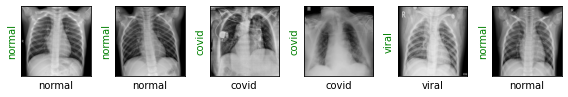

In [9]:
images, labels, fn = next(iter(dl_train))
show_images(images, labels, labels, fn)

Viral Pneumonia (191).png
NORMAL (222).png
NORMAL (973).png
COVID-19(476).png
COVID-19(270).png
Viral Pneumonia (801).png


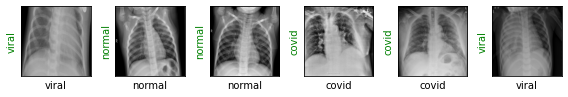

In [10]:
images, labels, fn = next(iter(dl_test))
show_images(images, labels, labels, fn)

# 7. Create the model

In [11]:
resnet18 = torchvision.models.resnet18(pretrained = True)

# print(resnet18)

In [12]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels, fn = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds, fn)

NORMAL (832).png
Viral Pneumonia (184).png
NORMAL (317).png
COVID-19 (53).png
Viral Pneumonia (701).png
Viral Pneumonia (819).png


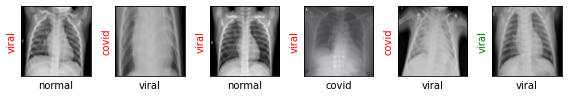

In [14]:
show_preds()

# 8. Train the model

In [15]:
def model_train(epochs):
    # define target accuracy, target validation loss, and test step tick
    target_acc = 0.975
    target_vl = 0.15
    ts_tick = 10
    
    print(str(dt), ': Starting model training...')
    for e in range(0, epochs):
        print('=' * 70)
        print(str(dt), f': Starting epoch {e + 1} / {epochs}')
        print('=' * 70)
        print(str(dt), f': Updating results every {ts_tick} training steps...')
        print('=' * 70)
        
        train_loss = 0.
        val_loss = 0.

        # set model to training phase
        resnet18.train() 

        for train_step, (images, labels, fn) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % ts_tick == 0:
                print(str(dt), ': Evaluating at step', train_step)

                accuracy = 0

                # set model to evaluation phase
                resnet18.eval() 

                for val_step, (images, labels, fn) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy / len(test_dataset)
                print(str(dt), f': Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()
                               
                # set model to training phase
                resnet18.train()

                if accuracy >= target_acc and val_loss <= target_vl:
                    print(str(dt), ': Target accuracy of ' + str(target_acc) + ' satisfied or exceeded.')
                    print(str(dt), ': Target validation loss of ' + str(target_vl) + ' satisfied or exceeded.')
                    print(str(dt), ': Stopping training...')
                    break

        train_loss /= (train_step + 1)
        print(str(dt), f': Training Loss: {train_loss:.4f}')
    print(str(dt), ': Training complete.')
    print(str(dt), ': Using best model trained in step ' + str(train_step) + ', epoch ' + f'{e + 1}' +'.')


2020-09-06 18:06:45 : Starting model training...
2020-09-06 18:06:45 : Starting epoch 1 / 1
2020-09-06 18:06:45 : Updating results every 10 training steps...
2020-09-06 18:06:45 : Evaluating at step 0
2020-09-06 18:06:45 : Validation Loss: 1.1927, Accuracy: 0.3267
NORMAL (222).png
Viral Pneumonia (488).png
Viral Pneumonia (1220).png
Viral Pneumonia (262).png
Viral Pneumonia (819).png
COVID-19 (121).png


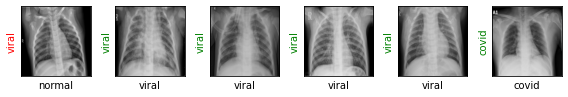

2020-09-06 18:06:45 : Evaluating at step 10
2020-09-06 18:06:45 : Validation Loss: 0.8292, Accuracy: 0.6667
NORMAL (580).png
COVID-19 (43).png
COVID-19 (121).png
NORMAL (780).png
COVID-19 (103).png
NORMAL (818).png


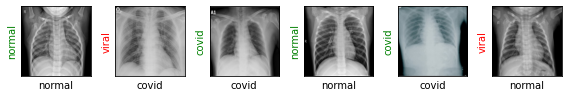

2020-09-06 18:06:45 : Evaluating at step 20
2020-09-06 18:06:45 : Validation Loss: 0.5481, Accuracy: 0.9200
COVID-19 (121).png
COVID-19(345).png
NORMAL (832).png
COVID-19(270).png
COVID-19(369).png
NORMAL (1154).png


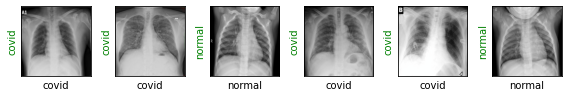

2020-09-06 18:06:45 : Evaluating at step 30
2020-09-06 18:06:45 : Validation Loss: 0.4093, Accuracy: 0.9200
COVID-19(143).png
COVID-19 (10).png
COVID-19(177).png
COVID-19(571).png
Viral Pneumonia (191).png
NORMAL (262).png


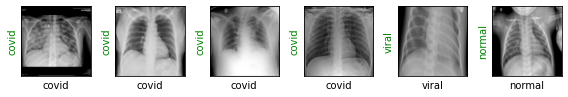

2020-09-06 18:06:45 : Evaluating at step 40
2020-09-06 18:06:45 : Validation Loss: 0.2577, Accuracy: 0.9400
COVID-19(351).png
Viral Pneumonia (323).png
Viral Pneumonia (124).png
Viral Pneumonia (694).png
Viral Pneumonia (801).png
Viral Pneumonia (1190).png


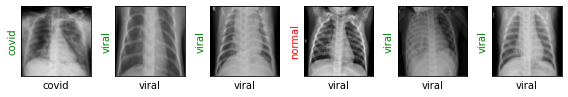

2020-09-06 18:06:45 : Evaluating at step 50
2020-09-06 18:06:45 : Validation Loss: 0.2911, Accuracy: 0.9067
NORMAL (1122).png
NORMAL (854).png
COVID-19(351).png
COVID-19 (22).png
Viral Pneumonia (1060).png
NORMAL (137).png


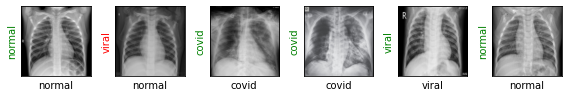

2020-09-06 18:06:45 : Evaluating at step 60
2020-09-06 18:06:45 : Validation Loss: 0.2092, Accuracy: 0.9467
COVID-19(305).png
NORMAL (300).png
NORMAL (839).png
NORMAL (1154).png
COVID-19(263).png
Viral Pneumonia (488).png


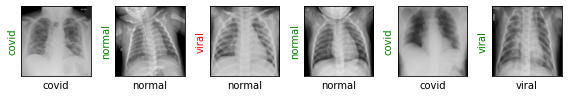

2020-09-06 18:06:45 : Evaluating at step 70
2020-09-06 18:06:45 : Validation Loss: 0.2310, Accuracy: 0.9467
Viral Pneumonia (370).png
COVID-19(571).png
Viral Pneumonia (964).png
COVID-19(351).png
NORMAL (854).png
Viral Pneumonia (559).png


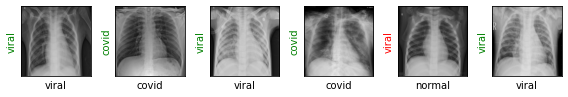

2020-09-06 18:06:45 : Evaluating at step 80
2020-09-06 18:06:45 : Validation Loss: 0.1852, Accuracy: 0.9667
COVID-19(531).png
Viral Pneumonia (1035).png
Viral Pneumonia (958).png
COVID-19(459).png
Viral Pneumonia (675).png
Viral Pneumonia (924).png


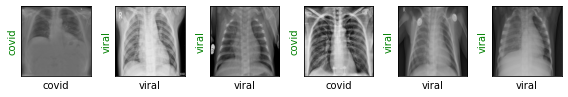

2020-09-06 18:06:45 : Evaluating at step 90
2020-09-06 18:06:45 : Validation Loss: 0.2048, Accuracy: 0.9467
NORMAL (1157).png
COVID-19(402).png
NORMAL (809).png
NORMAL (413).png
COVID-19(626).png
NORMAL (543).png


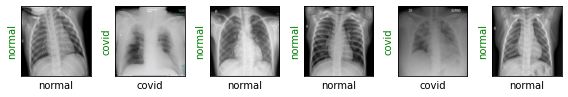

2020-09-06 18:06:45 : Evaluating at step 100
2020-09-06 18:06:45 : Validation Loss: 0.1501, Accuracy: 0.9667
COVID-19 (63).png
Viral Pneumonia (262).png
NORMAL (883).png
NORMAL (317).png
Viral Pneumonia (1156).png
Viral Pneumonia (1220).png


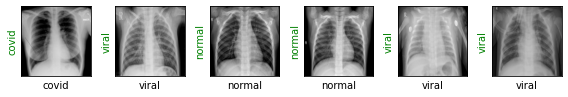

2020-09-06 18:06:45 : Evaluating at step 110
2020-09-06 18:06:45 : Validation Loss: 0.1968, Accuracy: 0.9533
NORMAL (876).png
NORMAL (577).png
Viral Pneumonia (700).png
Viral Pneumonia (58).png
COVID-19 (103).png
NORMAL (580).png


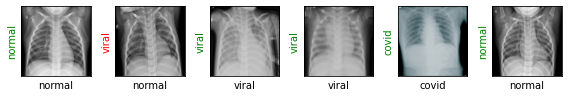

2020-09-06 18:06:45 : Evaluating at step 120
2020-09-06 18:06:45 : Validation Loss: 0.1134, Accuracy: 0.9733
NORMAL (226).png
COVID-19(476).png
COVID-19(213).png
Viral Pneumonia (1220).png
NORMAL (200).png
COVID-19 (14).png


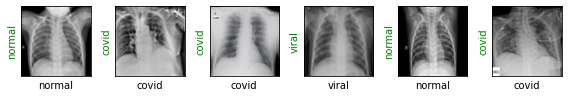

2020-09-06 18:06:45 : Evaluating at step 130
2020-09-06 18:06:45 : Validation Loss: 0.1365, Accuracy: 0.9733
NORMAL (543).png
NORMAL (354).png
Viral Pneumonia (819).png
NORMAL (854).png
Viral Pneumonia (184).png
Viral Pneumonia (1220).png


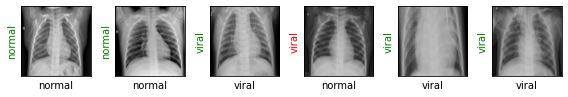

2020-09-06 18:06:45 : Evaluating at step 140
2020-09-06 18:06:45 : Validation Loss: 0.1201, Accuracy: 0.9667
COVID-19(138).png
NORMAL (98).png
NORMAL (1267).png
Viral Pneumonia (11).png
COVID-19 (22).png
NORMAL (780).png


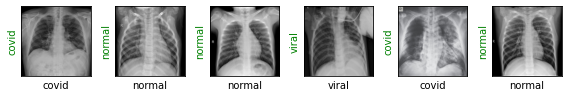

2020-09-06 18:06:45 : Evaluating at step 150
2020-09-06 18:06:45 : Validation Loss: 0.1647, Accuracy: 0.9600
COVID-19(402).png
COVID-19 (103).png
Viral Pneumonia (1311).png
NORMAL (973).png
Viral Pneumonia (1220).png
NORMAL (372).png


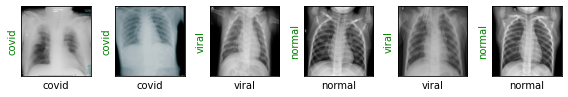

2020-09-06 18:06:45 : Evaluating at step 160
2020-09-06 18:06:45 : Validation Loss: 0.1539, Accuracy: 0.9667
NORMAL (318).png
NORMAL (809).png
COVID-19(177).png
NORMAL (764).png
Viral Pneumonia (701).png
Viral Pneumonia (967).png


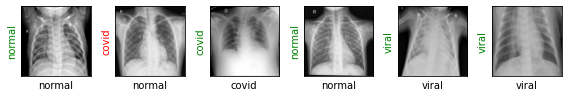

2020-09-06 18:06:45 : Evaluating at step 170
2020-09-06 18:06:45 : Validation Loss: 0.1296, Accuracy: 0.9667
Viral Pneumonia (206).png
COVID-19(468).png
COVID-19 (111).png
Viral Pneumonia (819).png
NORMAL (780).png
Viral Pneumonia (191).png


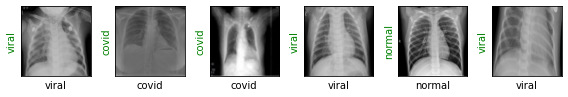

2020-09-06 18:06:45 : Evaluating at step 180
2020-09-06 18:06:45 : Validation Loss: 0.1216, Accuracy: 0.9667
COVID-19(625).png
COVID-19(571).png
NORMAL (535).png
COVID-19(301).png
COVID-19 (14).png
Viral Pneumonia (1035).png


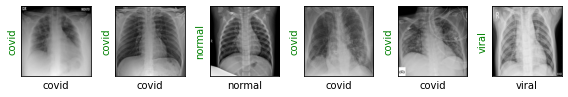

2020-09-06 18:06:45 : Evaluating at step 190
2020-09-06 18:06:45 : Validation Loss: 0.1069, Accuracy: 0.9733
Viral Pneumonia (1247).png
COVID-19(342).png
Viral Pneumonia (488).png
COVID-19 (111).png
Viral Pneumonia (262).png
COVID-19 (22).png


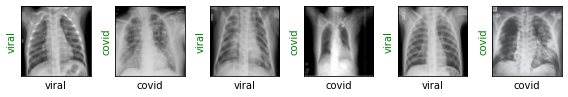

2020-09-06 18:06:45 : Evaluating at step 200
2020-09-06 18:06:45 : Validation Loss: 0.1161, Accuracy: 0.9533
Viral Pneumonia (586).png
COVID-19(248).png
COVID-19(301).png
NORMAL (579).png
Viral Pneumonia (724).png
COVID-19 (49).png


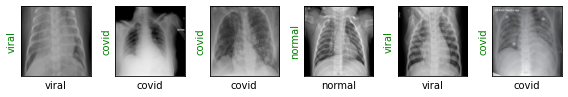

2020-09-06 18:06:45 : Evaluating at step 210
2020-09-06 18:06:45 : Validation Loss: 0.1159, Accuracy: 0.9867
Viral Pneumonia (194).png
Viral Pneumonia (675).png
Viral Pneumonia (224).png
COVID-19(447).png
NORMAL (1267).png
Viral Pneumonia (452).png


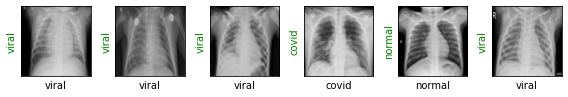

2020-09-06 18:06:45 : Target accuracy of 0.975 satisfied or exceeded.
2020-09-06 18:06:45 : Target validation loss of 0.15 satisfied or exceeded.
2020-09-06 18:06:45 : Stopping training...
2020-09-06 18:06:45 : Training Loss: 0.3411
2020-09-06 18:06:45 : Training complete.
2020-09-06 18:06:45 : Using best model trained in step 210, epoch 1.
Wall time: 5min 35s


In [16]:
%%time

epochs = 1
model_train(epochs)


# 9. Display the final results

Viral Pneumonia (682).png
NORMAL (348).png
Viral Pneumonia (1177).png
Viral Pneumonia (486).png
COVID-19(167).png
COVID-19 (14).png


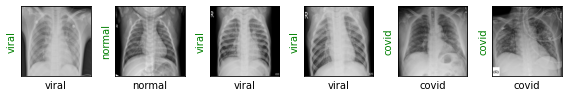

In [17]:
show_preds()